In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import innvestigate
import innvestigate.utils as iutils
import innvestigate.utils.tests.networks.imagenet
import innvestigate.utils.visualizations as ivis
import sys

import keras.backend
from keras.models import Model
from keras.layers import Input
from keras.layers.merge import Multiply
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution1D, AveragePooling1D

from keras import backend as K

import utils_imagenet as imgnetutils

Using TensorFlow backend.


In [2]:
def PREPROCESS(lines):
    data_n = len(lines) - 1
    SEQ = np.zeros((data_n, 34, 4), dtype=int)
    CA = np.zeros((data_n, 1), dtype=float)
    
    for l in range(1, data_n+1):
        data = lines[l].split()
        seq = data[0]
        for i in range(34):
            if seq[i] in "Aa":
                SEQ[l-1, i, 0] = 1
            elif seq[i] in "Cc":
                SEQ[l-1, i, 1] = 1
            elif seq[i] in "Gg":
                SEQ[l-1, i, 2] = 1
            elif seq[i] in "Tt":
                SEQ[l-1, i, 3] = 1
        CA[l-1, 0] = float(data[1])

    return SEQ, CA

In [3]:
print("Usage: python DeepCpf1.py input.txt output.txt")
print("input.txt must include 3 columns with single header row")
print("\t1st column: sequence index")
print("\t2nd column: 34bp target sequence")
print("\t3rd column: binary chromain information of the target sequence\n")

print("DeepCpf1 currently requires python=2.7.12, theano=0.7.0, keras=0.3.3")
print("DeepCpf1 available on GitHub requires pre-obtained binary chromatin information (DNase-seq narraow peak data from ENCODE)")
print("DeepCpf1 web tool, available at http://data.snu.ac.kr/DeepCpf1, provides entire pipeline including binary chromatin accessibility for 125 cell lines\n")

if len(sys.argv) < 3:
    sys.exit()

print("Building models")
Seq_deepCpf1_Input_SEQ = Input(shape=(34,4))
Seq_deepCpf1_C1 = Convolution1D(80, 5, activation='relu')(Seq_deepCpf1_Input_SEQ)
Seq_deepCpf1_P1 = AveragePooling1D(2)(Seq_deepCpf1_C1)
Seq_deepCpf1_F = Flatten()(Seq_deepCpf1_P1)
Seq_deepCpf1_DO1= Dropout(0.3)(Seq_deepCpf1_F)
Seq_deepCpf1_D1 = Dense(80, activation='relu')(Seq_deepCpf1_DO1)
Seq_deepCpf1_DO2= Dropout(0.3)(Seq_deepCpf1_D1)
Seq_deepCpf1_D2 = Dense(40, activation='relu')(Seq_deepCpf1_DO2)
Seq_deepCpf1_DO3= Dropout(0.3)(Seq_deepCpf1_D2)
Seq_deepCpf1_D3 = Dense(40, activation='relu')(Seq_deepCpf1_DO3)
Seq_deepCpf1_DO4= Dropout(0.3)(Seq_deepCpf1_D3)
Seq_deepCpf1_Output = Dense(1, activation='linear')(Seq_deepCpf1_DO4)
Seq_deepCpf1 = Model(inputs=[Seq_deepCpf1_Input_SEQ], outputs=[Seq_deepCpf1_Output])

DeepCpf1_Input_SEQ = Input(shape=(34,4))
DeepCpf1_C1 = Convolution1D(80, 5, activation='relu')(DeepCpf1_Input_SEQ)
DeepCpf1_P1 = AveragePooling1D(2)(DeepCpf1_C1)
DeepCpf1_F = Flatten()(DeepCpf1_P1)
DeepCpf1_DO1= Dropout(0.3)(DeepCpf1_F)
DeepCpf1_D1 = Dense(80, activation='relu')(DeepCpf1_DO1)
DeepCpf1_DO2= Dropout(0.3)(DeepCpf1_D1)
DeepCpf1_D2 = Dense(40, activation='relu')(DeepCpf1_DO2)
DeepCpf1_DO3= Dropout(0.3)(DeepCpf1_D2)
DeepCpf1_D3_SEQ = Dense(40, activation='relu')(DeepCpf1_DO3)

DeepCpf1_Input_CA = Input(shape=(1,))
DeepCpf1_D3_CA = Dense(40, activation='relu')(DeepCpf1_Input_CA)
DeepCpf1_M = Multiply()([DeepCpf1_D3_SEQ, DeepCpf1_D3_CA])

DeepCpf1_DO4= Dropout(0.3)(DeepCpf1_M)
DeepCpf1_Output = Dense(1, activation='linear')(DeepCpf1_DO4)
DeepCpf1 = Model(inputs=[DeepCpf1_Input_SEQ, DeepCpf1_Input_CA], outputs=[DeepCpf1_Output])

print("Loading weights for the models")
Seq_deepCpf1.load_weights('weights/my_weights.h5')
DeepCpf1.load_weights('weights/DeepCpf1_weights.h5')

print("Loading test data")
FILE = open("Heatmapping/training.txt", "r")
data = FILE.readlines()
SEQ, IF = PREPROCESS(data)
FILE.close()

print("Predicting on test data")
Seq_deepCpf1_SCORE = Seq_deepCpf1.predict([SEQ], batch_size=50, verbose=0)
#DeepCpf1_SCORE = DeepCpf1.predict([SEQ, CA], batch_size=50, verbose=0) * 3

print("Saving to " + sys.argv[2])
OUTPUT = open("Heatmapping/output_training.txt", "w")
for l in range(len(data)):
    if l == 0:
        OUTPUT.write(data[l].strip())
        OUTPUT.write("\tSeq-deepCpf1 Score\tDeepCpf1 Score\n")
    else:
        OUTPUT.write(data[l].strip())
        #OUTPUT.write("\t%f\t%f\n" % (Seq_deepCpf1_SCORE[l-1], DeepCpf1_SCORE[l-1]))
        OUTPUT.write("\t%f\n" % (Seq_deepCpf1_SCORE[l-1]))
OUTPUT.close()

Usage: python DeepCpf1.py input.txt output.txt
input.txt must include 3 columns with single header row
	1st column: sequence index
	2nd column: 34bp target sequence
	3rd column: binary chromain information of the target sequence

DeepCpf1 currently requires python=2.7.12, theano=0.7.0, keras=0.3.3
DeepCpf1 available on GitHub requires pre-obtained binary chromatin information (DNase-seq narraow peak data from ENCODE)
DeepCpf1 web tool, available at http://data.snu.ac.kr/DeepCpf1, provides entire pipeline including binary chromatin accessibility for 125 cell lines

Building models


Loading weights for the models


Loading test data


Predicting on test data


Saving to C:\Users\Sebastian\AppData\Roaming\jupyter\runtime\kernel-eb00c8d7-f1e5-45f1-a5b3-20cdc92d13fe.json


Analyzing SeqDeepCpf1


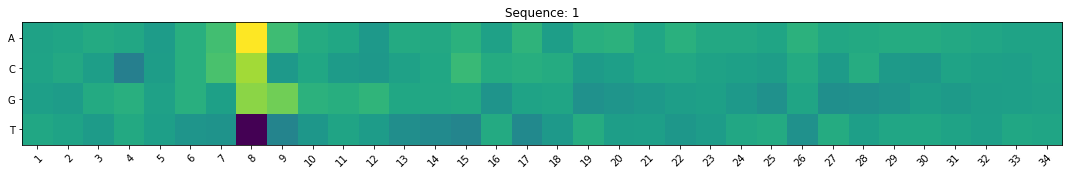

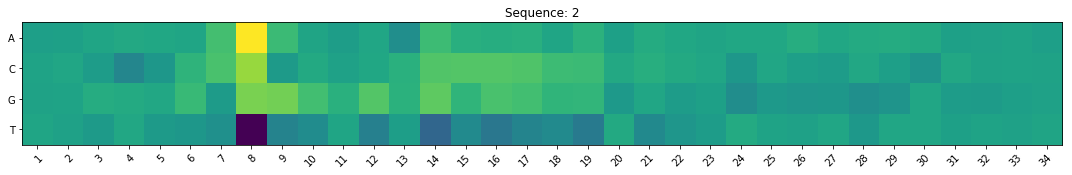

In [4]:
plt.rcParams["figure.figsize"] = (15, 10)
#Analyze

print("Analyzing SeqDeepCpf1")
analyzer = innvestigate.create_analyzer("gradient", Seq_deepCpf1)
analysis = analyzer.analyze(SEQ[:2])

grid = [[analysis[i, j] for j in range(analysis.shape[1])]
        for i in range(analysis.shape[0])]

positions = range(1,35)
bases = ["A", "C", "G", "T"]

for i in range(0,len(grid)):
    sequence = np.transpose(grid[i])
    
    fig, ax = plt.subplots()
    im = ax.imshow(sequence)
    
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(positions)))
    ax.set_yticks(np.arange(len(bases)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(positions)
    ax.set_yticklabels(bases)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    #for i in range(len(bases)):
    #    for j in range(len(positions)):
    #        text = ax.text(j, i, harvest[i, j],
    #                       ha="center", va="center", color="w")
    
    ax.set_title("Sequence: "+str(i+1))
    fig.tight_layout()
    plt.show()

In [7]:
pattern_type = "relu"
channels_first = keras.backend.image_data_format == "channels_first"
analysis_all = []
text = []
        
    # Create analyzers.
#    patterns = net["patterns"]
methods = [
    # NAME                      OPT.PARAMS                POSTPROC FXN                TITLE

    # Show input.
    ("input",                   {},                       imgnetutils.image,   "Input"),

    # Function
    ("gradient",                {},                       imgnetutils.graymap, "Gradient"),
    ("integrated_gradients",    {},                       imgnetutils.graymap, "Integrated Gradients"),

    # Signal
    ("deconvnet",               {},                       imgnetutils.bk_proj, "Deconvnet"),
    ("guided_backprop",         {},                       imgnetutils.bk_proj, "Guided Backprop"),
    #("pattern.net",             {"patterns": patterns},   imgnetutils.bk_proj, "PatterNet"),

    # Interaction
    #("pattern.attribution",     {"patterns": patterns},   imgnetutils.heatmap, "Pattern Attribution"),
    ("lrp.epsilon",             {"epsilon": 1},           imgnetutils.heatmap, "LRP Epsilon"),
    #("lrp.sequential_preset_a_flat", {"epsilon": 1},      imgnetutils.heatmap, "LRP-PresetAFlat"),
    #("lrp.sequential_preset_b_flat", {"epsilon": 1},      imgnetutils.heatmap, "LRP-PresetBFlat"),
]     





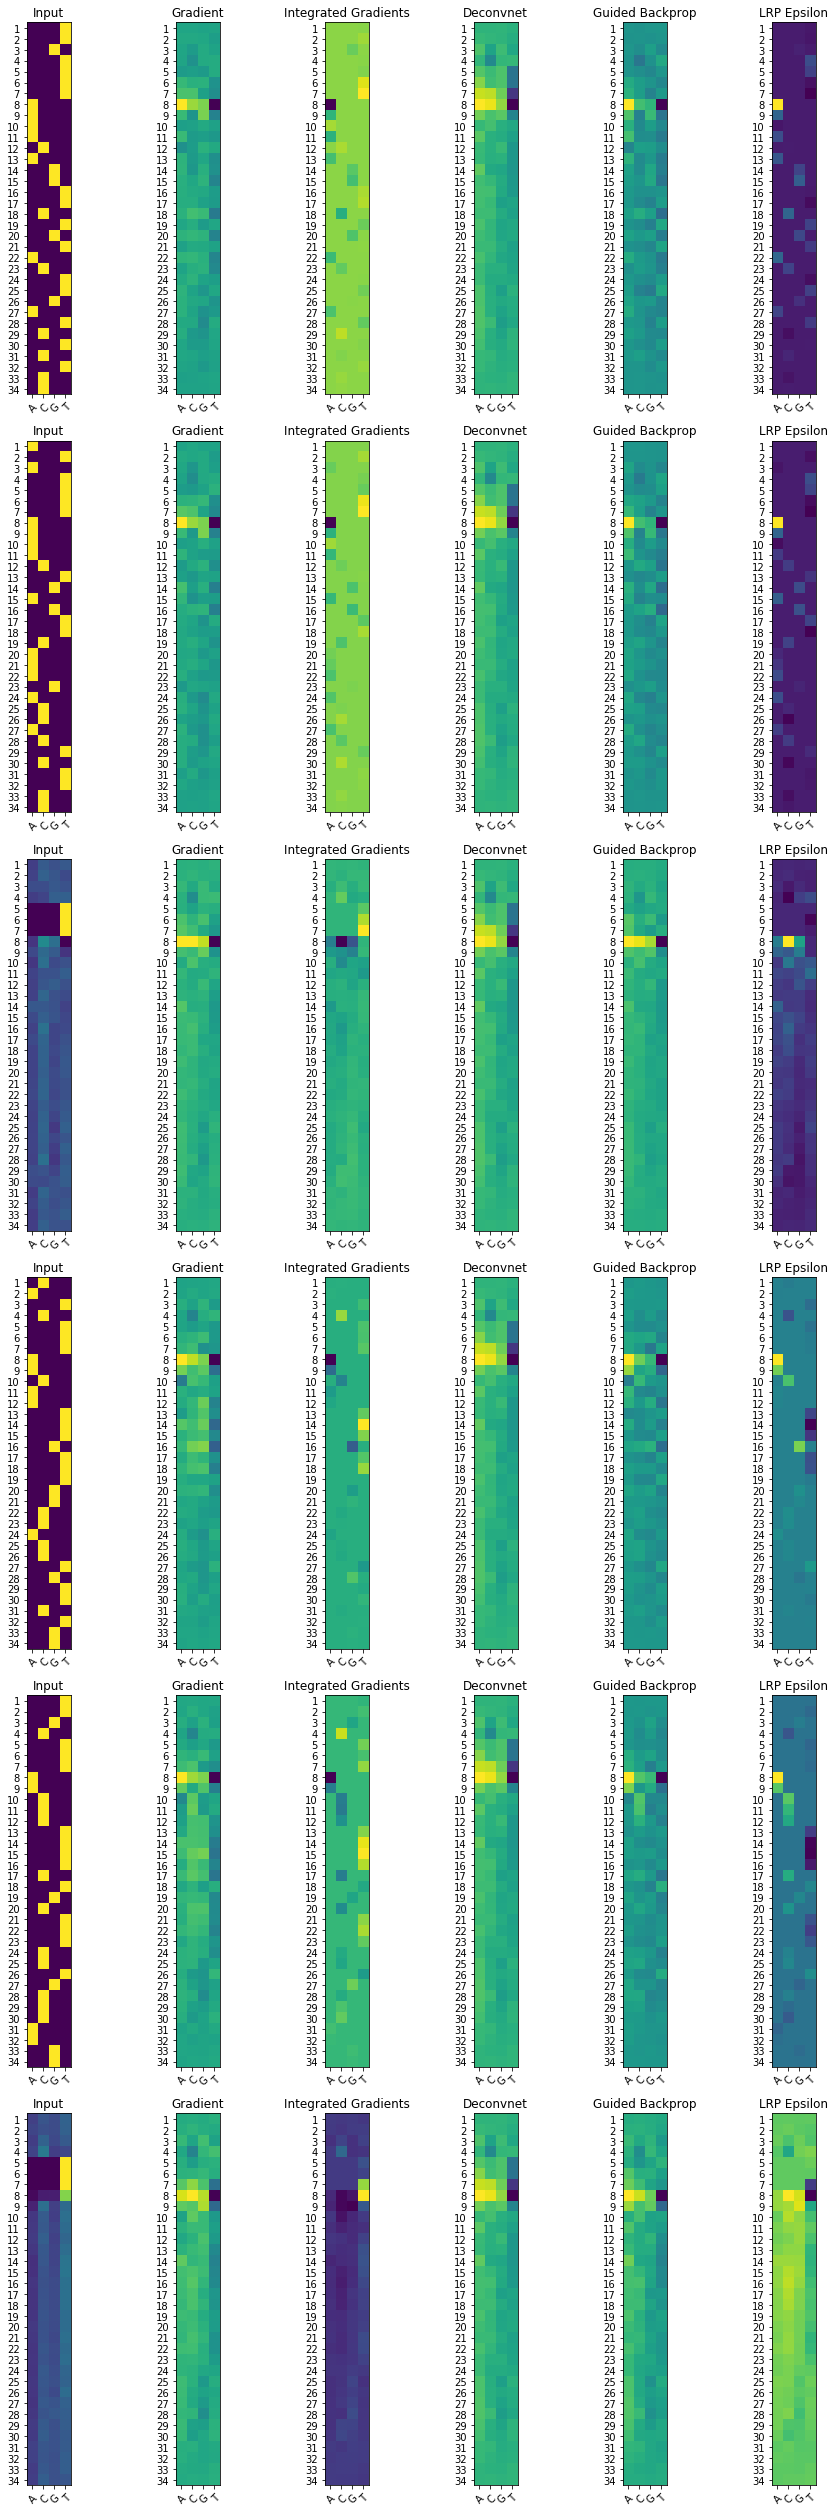

In [8]:
plt.rcParams["figure.figsize"] = (13, 35)

import pandas as pd
score = np.concatenate(Seq_deepCpf1_SCORE)
split = pd.qcut(score, 4, labels=False)

model = Seq_deepCpf1
numToPlot = 6

# Create analyzers.
analyzers = []
for method in methods:
    try:
        analyzer = innvestigate.create_analyzer(method[0],
                                                model,
                                                **method[1])
    except innvestigate.NotAnalyzeableModelException:
        analyzer = None
    analyzers.append(analyzer)

fig, ax = plt.subplots(numToPlot, len(analyzers))

for j in range(0, len(analyzers)):
    if analyzers[j] is not None:
        
        analysisTop = analyzers[j].analyze(SEQ[split == 3])
        analysisBot = analyzers[j].analyze(SEQ[split == 0])
        
        gridTop = [[analysisTop[i, j] for j in range(analysisTop.shape[1])]
                   for i in range(analysisTop.shape[0])]
        
        gridBot = [[analysisBot[i, j] for j in range(analysisBot.shape[1])]
                   for i in range(analysisBot.shape[0])]
        
        positions = list(range(1, 35))
        bases = ["A", "C", "G", "T"]
        
        for i in range(0, numToPlot):
            if i <= 1:
                # plot best quartile
                sequence = gridTop[i]
                im = ax[i, j].imshow(sequence)
                
            elif i == 2:
                # plot best quartile average
                sequence = np.average(gridTop, axis=0)
                im = ax[i, j].imshow(sequence)
                
            elif i <= 4:
                # plot worst quartile
                sequence = gridBot[i]
                im = ax[i, j].imshow(sequence)
                
            else:
                # plot worst quartile average
                sequence = np.average(gridBot, axis=0)
                im = ax[i, j].imshow(sequence)
            
            # We want to show all ticks...
            ax[i, j].set_xticks(np.arange(len(bases)))
            ax[i, j].set_yticks(np.arange(len(positions)))
            # ... and label them with the respective list entries
            ax[i, j].set_xticklabels(bases)
            ax[i, j].set_yticklabels(positions)
            
            # Rotate the tick labels and set their alignment.
            plt.setp(ax[i, j].get_xticklabels(), rotation=45, ha="right",
                     rotation_mode="anchor")
            
            ax[i, j].set_title(methods[j][3])
            fig.tight_layout()
            
            
plt.show()

print("OUTPUT\tTRUE LABEL")
print(score[split == 3][0], "\t", IF[split == 3][0])
print(score[split == 3][1], "\t", IF[split == 3][1])
print(np.average(score[split == 3]), np.average(IF[split == 3]))
print(score[split == 0][0], "\t", IF[split == 0][0])
print(score[split == 0][1], "\t", IF[split == 0][1])
print(np.average(score[split == 0]), np.average(IF[split == 0]))

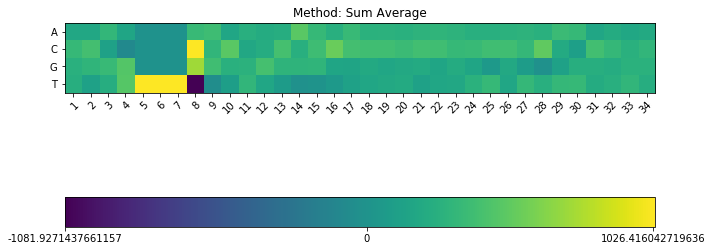

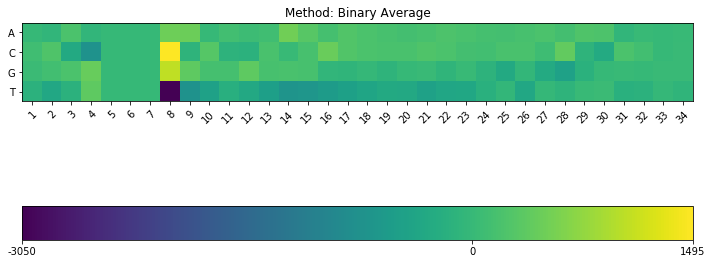

In [9]:
plt.rcParams["figure.figsize"] = (10, 10)

sum_SEQ = np.zeros((34, 4), dtype=float)

topSEQ = SEQ[split == 3]
botSEQ = SEQ[split == 0]

topScore = score[split == 3]
botScore = score[split == 0]

top = []
for l in range(len(topSEQ)):
    top.append(topScore[l] * topSEQ[l])

bot = []
for l in range(len(botSEQ)):
    bot.append(botScore[l] * botSEQ[l])
    
top = (top-np.min(top))/(np.max(top)-np.min(top))
bot = (bot-np.min(bot))/(np.max(bot)-np.min(bot))

for l in range(len(top)):
    sum_SEQ = sum_SEQ + top[l] - bot[l]
    
# plot
sequence = np.transpose(sum_SEQ)

positions = list(range(1, 35))
bases = ["A", "C", "G", "T"]

fig, ax = plt.subplots()
im = ax.imshow(sequence)

# We want to show all ticks...
ax.set_xticks(np.arange(len(positions)))
ax.set_yticks(np.arange(len(bases)))
# ... and label them with the respective list entries
ax.set_xticklabels(positions)
ax.set_yticklabels(bases)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

cbar = fig.colorbar(im, ticks=[np.min(sequence), 0, np.max(sequence[sequence != np.max(sequence)])], orientation='horizontal')
cbar.ax.set_xticklabels([np.min(sequence), "0", np.max(sequence[sequence!=np.max(sequence)])])  # horizontal colorbar

ax.set_title("Method: Sum Average")
fig.tight_layout()
plt.show()




plt.rcParams["figure.figsize"] = (10, 10)
#plot
sequence = np.transpose(np.sum(np.add(topSEQ, botSEQ*(-1)), axis=0))

positions = list(range(1, 35))
bases = ["A", "C", "G", "T"]

fig, ax = plt.subplots()
im = ax.imshow(sequence)

# We want to show all ticks...
ax.set_xticks(np.arange(len(positions)))
ax.set_yticks(np.arange(len(bases)))
# ... and label them with the respective list entries
ax.set_xticklabels(positions)
ax.set_yticklabels(bases)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title("Method: Binary Average")

cbar = fig.colorbar(im, ticks=[np.min(sequence), 0, np.max(sequence)], orientation='horizontal')
cbar.ax.set_xticklabels([np.min(sequence), '0', np.max(sequence)])  # horizontal colorbar

fig.tight_layout()
plt.show()

In [10]:
from scipy.stats import spearmanr

print(np.average(IF[split == 3]))
print(np.average(score[split == 3]))

print(spearmanr(IF, score))

71.57189547931254
65.29549
SpearmanrResult(correlation=0.7663084921068364, pvalue=0.0)


In [11]:
#clean shutdown for tf.

if K.backend() == 'tensorflow':
    K.clear_session()